# Deep Learning with Python

# 3. Sequential Model

## 3.1. Simple Convolution Neural Network

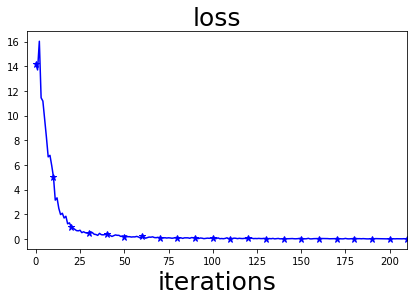

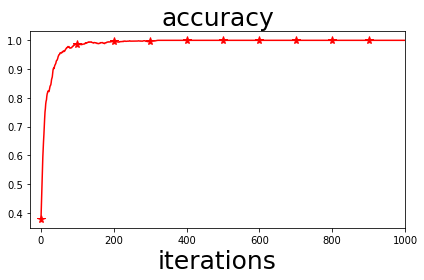

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from deepL_module.datasets.mnist import load_mnist
from deepL_module.nn.sequential import Sequential
from deepL_module.nn.optimizers import *
from deepL_module.base import *
from deepL_module.nn.layers import *
from deepL_module.nn import *
%matplotlib inline

max_iter = 1000


'''#0 loading data '''
(X_train, train_t), (X_test, test_t) = load_mnist(normalize=True, flatten=False)
X_train, train_t = X_train[:500], train_t[:500]
train_t = to_categorical(train_t)


'''#1 config for NN '''
model = Sequential()
model.add(Conv2D(16,(5,5),input_shape=(1,28,28))) # Covolution Layer
model.add(Activation('relu'))
model.add(Maxpooling(pool_h=2, pool_w=2, stride=2)) # Maxpooling 2D Layer
model.add(Dense(100, activation='relu'))
model.add(Dense(10))

# optimizer setting
routine = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=routine)


'''#2 learning '''
hist = model.fit(X_train, train_t,
                 batch_size=256,
                 n_iter=max_iter,
                 history=True)


'''#3 drawing loss & accuracy data '''
# ----- loss data -----
fig=plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
x = np.arange(max_iter)
ax1.plot(x, hist['loss'], color='blue',marker="*", markersize=7, markevery=10,label='loss')
ax1.set_xlabel("iterations",fontsize=25)
ax1.set_title("loss",fontsize=25)
ax1.set_xlim([-5,210])
plt.show()

# --- accuracy data ---
fig.add_subplot(122)
plt.plot(x, smooth_filt(hist['acc']),
        color = 'red',
        marker = "*",
        markersize = 8,
        markevery = 100,
        label='accuracy')
plt.xlabel("iterations",fontsize=25)
plt.title("accuracy",fontsize=25)
plt.xlim([-30,1000])
plt.tight_layout()
plt.show()

## 3.2. The effect of Batch normalization

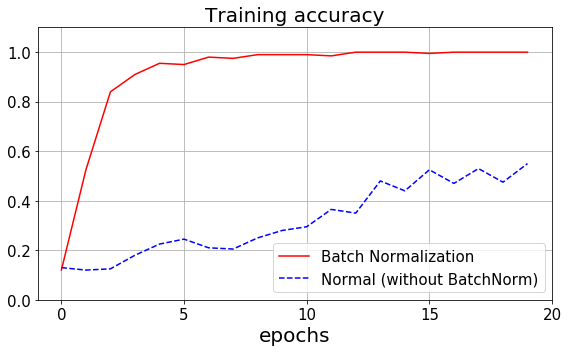

In [2]:
import matplotlib.pyplot as plt
from deepL_module.datasets.mnist import load_mnist
from deepL_module.nn.sequential import Sequential
from deepL_module.nn.multi_layer_nn import *
from deepL_module.nn.optimizers import *
from deepL_module.base import *
from deepL_module.nn.layers import *
import copy

# === loading data ===
(X_train, train_t), (X_test, test_t) = load_mnist(normalize=True)

# data reduction
X_train = X_train[:1000]
train_t = train_t[:1000]
train_t = to_categorical(train_t)

# setting parameters
max_epochs = 20
train_size = X_train.shape[0]
batch_size = 200
learning_rate = 0.01
scale = 0.005
iter_per_epoch = max(train_size / batch_size, 1)
max_iter = int(max_epochs * iter_per_epoch)

# constructing model
model = Sequential(w_std=scale)
model.add(Dense(50, input_dim=784, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(70, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10))


bn_model = Sequential(w_std=scale)

bn_model.add(Dense(50, input_dim=784))
bn_model.add(Batch_norm_Layer())
bn_model.add(Activation('relu'))

bn_model.add(Dense(100))
bn_model.add(Batch_norm_Layer())
bn_model.add(Activation('relu'))

bn_model.add(Dense(70))
bn_model.add(Batch_norm_Layer())
bn_model.add(Activation('relu'))

bn_model.add(Dense(100))
bn_model.add(Batch_norm_Layer())
bn_model.add(Activation('relu'))

bn_model.add(Dense(10))


model_dict = {'batch_norm':bn_model, 'normal':model}
train_acc = {}


'''---- learning ----'''
for name, network_ in model_dict.items():
    optim = Adam(lr=learning_rate)
    network_.compile(loss='categorical_crossentropy', optimizer=optim)
    hist = network_.fit(X_train, train_t,
                        n_iter=max_iter,
                        batch_size=batch_size,
                        history=True)
    train_acc[name] = np.asarray(hist['acc'])


# drawing graph
x = np.arange(max_epochs)
idx = np.arange(0, max_iter, iter_per_epoch)
idx = list(map(int,idx))

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

ax.plot(x, train_acc['batch_norm'][idx],
        label='Batch Normalization', markevery=2, color='r')
ax.plot(x, train_acc['normal'][idx], linestyle = "--",
        label='Normal (without BatchNorm)', markevery=2, color='blue')

plt.legend(fontsize=15)
plt.title('Training accuracy', fontsize=20)
plt.xlabel('epochs',fontsize=20)
plt.xticks(np.arange(0,max_epochs+1,5),fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,1.1)
plt.tight_layout()
plt.grid()
plt.show()